In [19]:
import numpy as np
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.cross_validation import KFold
from collections import defaultdict
import copy
import matplotlib.pyplot as plt


In [3]:
def deserialize(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [17]:
def serialize(file_name,data):    
    with open(file_name, 'wb') as f:    
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)        

In [4]:
def get_Xmatrix_and_y(file_name):
    summ_data = deserialize(file_name)    
    X_mat = summ_data[:,0:len(summ_data[0])-1]
    y = summ_data[:,len(summ_data[0])-1:]
    return X_mat,y

In [5]:
def train_regressor(optimizer,hidden_layer_units,activation_func,epochs):
    '''Fit an MLP with the specified settings and return the trained regressor'''
    '''Optimizer : Any of lbfgs,sgd etc
        hidden_layer_units : A tuple of the form (x,y,z) where x is the no of units in 1st hidden layer,y in 2nd and so on                            
       activation_fun : logistic / tanh / relu
       epochs : No of epochs
       X : Train Matrix
       y : True values
    '''
    regr = MLPRegressor(solver=optimizer,hidden_layer_sizes=hidden_layer_units,activation=activation_func,max_iter=epochs)        
    return regr

In [6]:
def do_cross_validation(X_Matrix,Y,clf,n_folds):
    '''Perform n-fold cross validation.    
    Params:
        X.........a Matrix of features
        y.........the true rogue score of each sentence
        n_folds...the number of folds of cross-validation to do
        
    Return:
        the average testing accuracy across all folds.'''
    
    accuracies = []
    cv = KFold(len(Y), n_folds)
    for train_idx, test_idx in cv:        
        clf.fit(X_Matrix[train_idx], Y[train_idx])
        predicted = clf.predict(X_Matrix[test_idx])        
        error = np.mean(np.abs(predicted - Y[test_idx]))
        accuracies.append(error)                
    avg = np.mean(accuracies)    
    return avg

In [12]:
def run_mlp(optimizers,activation_funcs,epochs,hid_layer_sizes,X_mat,y):
    '''Run the MLP for settings specified in the parameters'''
    optimizer_act = defaultdict(defaultdict)
    for optimizer in optimizers:
        act_epoch = defaultdict(defaultdict)
        for act_func in activation_funcs:
            epoch_hl = defaultdict(defaultdict)
            for epoch in epochs:
                hl_err = defaultdict(float)
                for hid_layer_size in hid_layer_sizes:                
                    regr = train_regressor(optimizer,hid_layer_size,act_func,epoch)
                    error = do_cross_validation(X_mat,y,regr,10)
                    hl_err[len(hid_layer_size)] = error
                    print optimizer,act_func,epoch,len(hid_layer_size),'h_layers complete. Error = ',error
                epoch_hl[epoch] = copy.deepcopy(hl_err)
            act_epoch[act_func] = copy.deepcopy(epoch_hl)
        optimizer_act[optimizer] = copy.deepcopy(act_epoch)
    return optimizer_act

In [14]:
def get_best_hyperparams():
    '''Specify the various settings for hyperparameters here. Calls run_mlp to get the Validation error'''
    X_mat,y = get_Xmatrix_and_y('data_matrix')
    optimizers = ['sgd','adam','lbfgs'] 
    activation_funcs = ['tanh','logistic'] 
    epochs = [5,10,15,20]
    single_hl = (57,)
    double_hl = (57,57)
    triple_hl = (57,57,57)
    hid_layer_sizes = [single_hl,double_hl,triple_hl]
    return run_mlp(optimizers,activation_funcs,epochs,hid_layer_sizes,X_mat,y)

In [15]:
optimizer_act = get_best_hyperparams()

/home/karthik/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/karthik/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


sgd tanh 5 1 h_layers complete. Error =  0.148520558961
sgd tanh 5 2 h_layers complete. Error =  0.0929405603315
sgd tanh 5 3 h_layers complete. Error =  0.0747463619168
sgd tanh 10 1 h_layers complete. Error =  0.111809704268
sgd tanh 10 2 h_layers complete. Error =  0.0707638748782
sgd tanh 10 3 h_layers complete. Error =  0.0605437070714
sgd tanh 15 1 h_layers complete. Error =  0.0981586784956
sgd tanh 15 2 h_layers complete. Error =  0.0611465158951
sgd tanh 15 3 h_layers complete. Error =  0.0565694151612
sgd tanh 20 1 h_layers complete. Error =  0.0922672209436
sgd tanh 20 2 h_layers complete. Error =  0.0583734834247
sgd tanh 20 3 h_layers complete. Error =  0.0506870351454
sgd logistic 5 1 h_layers complete. Error =  0.0573891267701
sgd logistic 5 2 h_layers complete. Error =  0.0333304736126
sgd logistic 5 3 h_layers complete. Error =  0.0251837545414
sgd logistic 10 1 h_layers complete. Error =  0.05372801892
sgd logistic 10 2 h_layers complete. Error =  0.030329588842
sgd l

In [75]:
#serialize('MLP_Val_Err.pickle',optimizer_act)
optimizer_act = deserialize('MLP_Val_Err.pickle')

In [106]:
def plot_epoch_vs_errors(optimizer_act):
    '''Plot Epoch vs Validation Errors by varying the following :
       1. No of Hidden Layers
       2. No of Epochs
       3. Varying the optimizer
       4. Varying the activation function for each optimizer
    '''
    for optimizer in sorted(optimizer_act.keys()):
        for act_func in sorted(optimizer_act[optimizer].keys()):
            layer_error = defaultdict(list)
            for epoch in sorted(optimizer_act[optimizer][act_func].keys()):                 
                for h_layer in sorted(optimizer_act[optimizer][act_func][epoch].keys()):  
                    layer_error[h_layer].append(optimizer_act[optimizer][act_func][epoch][h_layer])

            x = sorted(optimizer_act[optimizer][act_func].keys())
            y_lst = []
            for lyr in sorted(optimizer_act[optimizer][act_func][epoch].keys()):
                y_lst.append(layer_error[lyr])

            plt.xlabel('Epochs')
            plt.ylabel('Validation Error')
            plt.plot(x,y_lst[0],'r-')
            plt.plot(x,y_lst[1],'g-')
            plt.plot(x,y_lst[2],'b-')
            plt.legend(['1 Hidden Layer', '2 Hidden Layers', '3 Hidden Layers'], loc='upper right',columnspacing=0.0, labelspacing=0.0,
            )
            title = optimizer.upper() + ' with ' + act_func.upper() + ' activation'
            plt.title(title)
            plt.show()

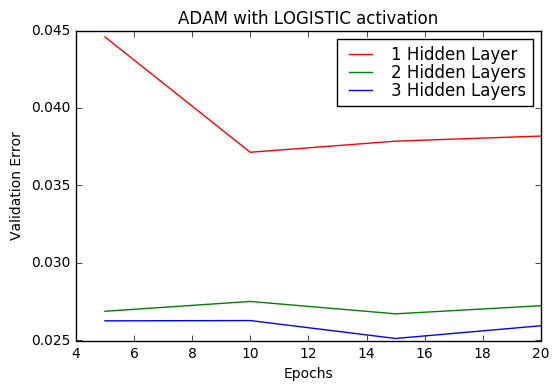

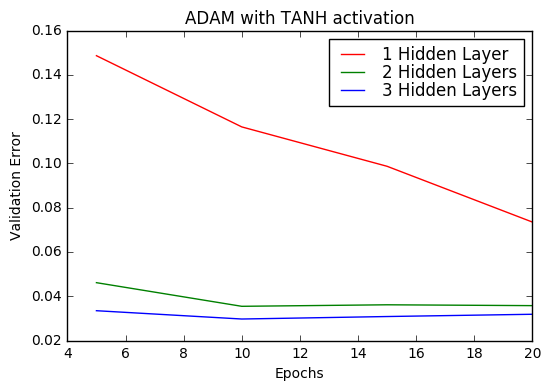

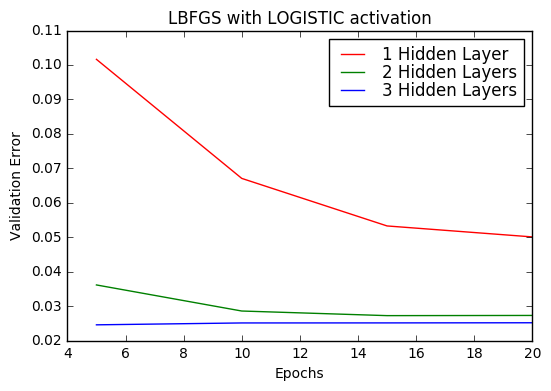

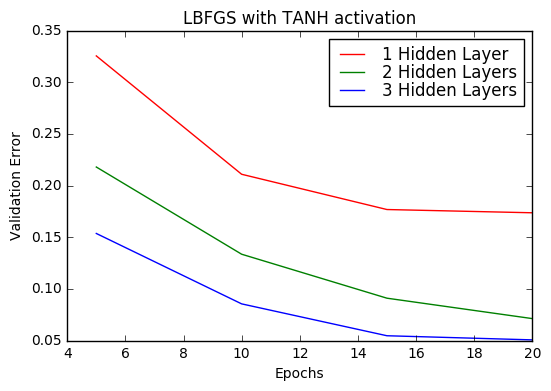

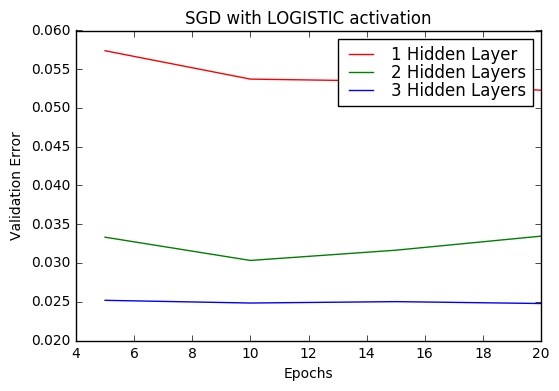

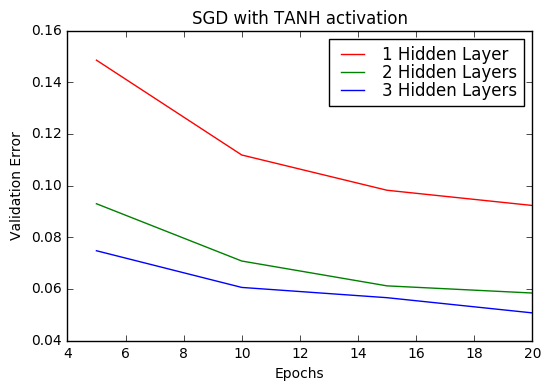

In [107]:
plot_epoch_vs_errors(optimizer_act)